<a href="https://colab.research.google.com/github/alessandrotofani/Tesi_magistrale/blob/master/5_Dinamic_model_alt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
from google.colab import drive
drive.mount('/content/drive')
from sklearn.model_selection import train_test_split

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install --quiet fastai==2.2.5

In [3]:
import sys 
sys.path.append('/content/drive/MyDrive/Tesi_magistrale/Tesi_magistrale')
import mf
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None

# Feature engineering and scaling

In [4]:
data = pd.read_csv('/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/data.csv')
data = mf.new_processing(data)
data = pd.get_dummies(data)

# Dinamic model

In [5]:
init_splits = 4 # numero di split su cui il modello iniziale (t=0) si allena 
incoming_splits = 2 # nuovi split che arrivano ad ogni nuovo dt, e su cui si allena il nuovo modello
tot_splits = 10 # split totali in cui sarà diviso il dataset

In [6]:
def get_split_id(data, init_splits, incoming_splits, tot_splits): # serve per splittare il dataset in tot_splits
  '''
  in
  data: dataset che si vuole splittare
  init_splits: numero di split su cui il modello iniziale (t=0) si allena 
  incoming_splits: nuovi split che arrivano ad ogni nuovo dt, e su cui si allena il nuovo modello
  tot_splits: split totali in cui sarà diviso il dataset
  out
  id: dizionario che contiene (split : id righe selezionate)
  id_fraud: come id, solo che sono selezionate solo le transazioni fraudolente 
  '''
  id = {} # dizionario con (split : id_righe)
  id_fraud = {} # dizionario con (split: id righe transazioni fraudolente)
  for i in range(tot_splits):
    id[i] = data[(data['TransactionDT']>=(i/tot_splits)) & (data['TransactionDT']<((i + 1)/tot_splits))].index.tolist()
    id_fraud[i] = data[(data['TransactionDT']>=(i/tot_splits)) & (data['TransactionDT']<((i + 1)/tot_splits)) & (data['isFraud'] == 1)].index.tolist()
    
  return id, id_fraud

In [7]:
class model:
  name = 'XGBoost'

  def __init__(self, t): # costruttore
    '''
    in
    t: istante temporale
    '''
    self.t = t
    self.f1 = 0
    self.precision = 0
    self.recall = 0
    self.roc = 0
    self.proba = []
    self.prediction = []
    self.train_id = [] # lista con le righe su cui il modello si è allenato
    self.val_id = [] # lista con le righe su cui il modello viene validato
    return

  def __str__(self): # print dell'oggetto
    return f"{self.name}, at time {self.t}, with f1 score of {self.f1}"

  def init_xgb(self, estimators = 10, depth = 6): # inizializza xgb 2000, 6
    import xgboost 
    from xgboost import XGBClassifier
    self.xgb = XGBClassifier(n_estimators = estimators, max_depth = depth, 
                      objective='binary:logistic', learning_rate = 0.5, 
                      tree_method='gpu_hist')
    return f'{self.name} at time {self.t}, has been initialized.'
  
  def train_xgb(self, X_train, y_train): # traina il modello
    # self.xgb.fit(X_train.to_numpy(), y_train.to_numpy())
    self.xgb.fit(X_train.to_numpy(), y_train)
    return f'{self.name} is now trained!'

  def get_set(self, data, id_list): # restituisce il subset dati gli id delle righe
    # id_list: è l'elemento id[t] 
    subset = data.iloc[id_list,:]
    return subset

  def proba_predictions(self, X_val): # restituisce le probabilità
    if not self.xgb:
      return f'{self.name} is not declared. You need to use init_xgb'
    self.proba = self.xgb.predict_proba(X_val, validate_features = False)
    return self.proba

  def aggregate(self, soglia = 0.05): # resituisce la classe
    # if not self.proba:
    #   return f'self.proba is empty. Before aggregate, you need to use proba_predictions'
    self.prediction = []
    for proba in self.proba[:,1]:
      if proba > soglia:
        self.prediction.append(1)
      else:
        self.prediction.append(0)
    return f'Classification has been councluded!'

  def performance(self, y_val, soglia = 0.05): # printa le performance del modello 
    from sklearn.metrics import roc_auc_score, f1_score, recall_score, precision_score
    
    print('\n')
    print('Confusion matrix of model', self.name,'of time', self.t)
    mf.plot_cm(y_val, self.prediction, 'Blues', p = soglia, dynamic = True)
    
    self.score = f1_score(y_val, self.prediction).round(2)
    self.roc = roc_auc_score(y_val, self.prediction).round(2)
    self.precision = precision_score(y_val, self.prediction,  average='binary').round(2)
    self.recall = recall_score(y_val, self.prediction, average='binary').round(2)

    print('\n')
    print('Model f1 score: ', self.score)
    print('Model roc auc score: ', self.roc)
    print('Model recall: ', self.recall)
    print('Model precision: ', self.precision)
    print('\n')
    return 

In [8]:
class svm(model):
  name = 'svm'

  def init_svm(self):
    from sklearn.svm import LinearSVC
    self.svm = LinearSVC(max_iter=10, #1000, 
                        random_state=0, tol=1e-2, class_weight='balanced',  
                        loss='squared_hinge', dual = False )
    return
  
  def train_svm(self, X_train, y_train):
    self.svm.fit(X_train, y_train)
    return

  #override
  def proba_predictions(self, X_val): # restituisce le probabilità
    if not self.svm:
      return f'{self.name} is not declared. You need to use init_nn'
    self.proba = self.svm.predict(X_val.to_numpy())#, validate_features = False)
    return self.proba

  #override
  def aggregate(self, soglia = 0.5): # resituisce la classe
    self.prediction = []
    for proba in self.proba:
      if proba > soglia:
        self.prediction.append(1)
      else:
        self.prediction.append(0)
    return f'Classification has been councluded!'

In [9]:
def underSampling(X, y, frac_under=0.1):
  from imblearn.under_sampling import RandomUnderSampler 
  us = RandomUnderSampler(sampling_strategy=frac_under, random_state=42)
  X_us, y_us = us.fit_resample(X, y)
  return X_us, y_us

def overSampling(X, y, frac_over=0.1):
  from imblearn.over_sampling import SMOTE
  sm = SMOTE(sampling_strategy=frac_over, random_state=42)
  X_sm, y_sm = sm.fit_resample(X, y)  
  return X_sm, y_sm

def mergeResult(X, y, col_name):
  y_res = np.ndarray(shape=(np.shape(y)[0],1), buffer = y)
  data = np.concatenate((X,y_res), axis = 1)
  col_name.append('isFraud')
  dataset = pd.DataFrame(data=data, columns=col_name)  
  return dataset

In [10]:
class nn(model):
  name = 'Neural network'

  def init_nn(self, n_features, col_name):
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Flatten, Dense, Dropout, Input, BatchNormalization
    self.col_name = col_name
    
    self.nn = Sequential()
    self.nn.add(Input(shape=(n_features,))) 
    self.nn.add(Dense(360, activation=tf.keras.activations.gelu)) 
    self.nn.add(BatchNormalization())
    self.nn.add(Dense(1, activation='sigmoid')) 

    self.nn.compile(loss='binary_crossentropy', 
                    optimizer='adam', 
                    metrics=['accuracy', 
                             tf.keras.metrics.Recall(), 
                             tf.keras.metrics.Precision()])
    return f'{self.name} initialized'

  def train_nn(self, X_train, y_train, frac = 0.1):
    import tensorflow as tf
    X_train_res, X_val, y_train_res, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
    history = self.nn.fit(X_train_res, y_train_res, 
                          epochs=30, batch_size=250, 
                          validation_data=(X_val, y_val), 
                          class_weight={0: 0.5, 1: 1},
                          verbose=1, shuffle = True)
    return f'{self.name} trained.'

  #override
  def proba_predictions(self, X_val): # restituisce le probabilità
    if not self.nn:
      return f'{self.name} is not declared. You need to use init_nn'
    self.proba = self.nn.predict(X_val.to_numpy())
    self.proba = np.reshape(self.proba, self.proba.shape[0])
    print(self.proba)
    return self.proba

  #override
  def aggregate(self, soglia = 0.5): # resituisce la classe
    self.prediction = []
    for proba in self.proba:
      if proba > soglia:
        self.prediction.append(1)
      else:
        self.prediction.append(0)
    return f'Classification has been councluded!'

In [11]:
class ensemble(model): # child class di model
  name = 'Ensemble'
  # come model_dict passare il dizionario in cui si salvano gli ensemble

  #override 
  def proba_predictions(self, model_dict, X_val): # restituisce le probabilità predette 
    prob = []
    for t in model_dict:
      if model_dict[t].name == 'XGBoost':
        prob.append(model_dict[t].proba_predictions(X_val)[:,1])
      if model_dict[t].name == 'Neural network':
        prob.append(model_dict[t].proba_predictions(X_val))
      if model_dict[t].name == 'svm':
        prob.append(model_dict[t].proba_predictions(X_val))
    self.proba = np.mean(prob, axis = 0)
    return f'Proba acquired.'
  
  #override
  def aggregate(self, soglia = 0.05): # restituisce la classe predetta 
    self.prediction = []
    for proba in self.proba:
      if proba > soglia:
        self.prediction.append(1)
      else:
        self.prediction.append(0)
    return f'Classification has been councluded!'

In [12]:
def get_t_id(data, id, id_fraud, t, init_splits, incoming_splits): # restituisce la lista degli id corrispondente all'istante temporale t 
  '''
  data: dataset da cui selezionare le transazioni
  id: lista con gli id delle righe
  t: istante temporale
  init_splits: split totali in cui sarà diviso il dataset
  incoming_splits: nuovi split che arrivano ad ogni nuovo dt, e su cui si allena il nuovo modello
  out
  id_list: lista con gli id delle righe selezionate a seconda dell'istante temporale specificato  
  '''
  id_list = [] # lista che conterrà le righe da usare al tempo t
  id_list_fraud = [] # lista che conterrà le righe con transazioni fraud da usare al tempo t

  if t == 0: 
    start = 0
    end = init_splits
  else:
    start = incoming_splits * (t - 1) + init_splits
    end = start + incoming_splits

  if t == 1:
    start_fraud = 0
    end_fraud = init_splits
  else:
    start_fraud = 0
    end_fraud = incoming_splits * (t - 1) + init_splits + incoming_splits 

    

  for n in range(start,end):
    id_list += id[n]
  
  if t > 0:
    for n in range(start_fraud, end_fraud):
      id_list_fraud += id_fraud[n]

  return id_list, id_list_fraud

In [13]:
def train_model(sel_model, last_model, data, id_t, id_fraud_t, keep_fraud, keep_safe): # funzione per sistemare il dataset e trainare il modello
  '''
  sel_model: modello da trainare
  data: dataset
  id_t: id delle righe su cui trainare il modello
  '''
  import random 



  # Train test split
  subset = sel_model.get_set(data, id_t) # seleziono il subset su cui il modello si allenerà
  X_train, X_val, y_train, y_val = mf.split(subset, test_size = 0.2) # train test split

  # unione transazioni fraudolente degli step precedenti
  if keep_fraud:
    X_train_fraud = sel_model.get_set(data, id_fraud_t)
    X_train_fraud.drop(columns = ['isFraud'], inplace = True)
  if keep_safe:
    sample_size = int(np.ceil(len(last_model.train_id) * 0.1))
    id_safe_t = random.sample(last_model.train_id, sample_size)
    X_train_safe = last_model.get_set(data, id_safe_t)
    X_train_safe.drop(columns = ['isFraud'], inplace = True)

  if keep_safe and keep_fraud:
    X_train = pd.concat([X_train, X_train_fraud, X_train_safe])
    y_train_safe = np.zeros(X_train_safe.shape[0])
    y_train_fraud = np.ones(X_train_fraud.shape[0])
    y_train = np.concatenate((y_train, y_train_fraud, y_train_safe), axis=None)

  if keep_safe and not keep_fraud:
    X_train = pd.concat([X_train, X_train_fraud])
    y_train_fraud = np.ones(X_train_fraud.shape[0])
    y_train = np.concatenate((y_train, y_train_fraud), axis=None)

  # salvataggio degli id nel modello
  sel_model.train_id = X_train.index.tolist() # salvo gli id del training set 
  sel_model.val_id = X_val.index.tolist() # salvo gli id del test set

  # Training del modello
  print('Training', sel_model.name)
  if sel_model.name == 'XGBoost':
    sel_model.init_xgb() # inizializzo xgb
    sel_model.train_xgb(X_train, y_train) # train di xgb 

  if sel_model.name == 'svm':
    sel_model.init_svm() # inizializzo xgb
    sel_model.train_svm(X_train, y_train) # train di xgb 
  
  if sel_model.name == 'Neural network':
    n_features = X_train.shape[1]
    col_name = mf.get_col(data)
    sel_model.init_nn(n_features, col_name)
    sel_model.train_nn(X_train, y_train)

  return f'Training ended. \n'

In [14]:
def test_model(sel_model, model_dict, t, data, soglia): # test del modello
  import operator
  '''
  in
  sel_model: modello da trainare
  model_dict: dizionario contenente i vari modelli
  t: istante temporale
  data: dataset
  soglia: soglia sulla probabilità 
  '''
  id_list = []
  for i in model_dict:
    id_list += model_dict[i].val_id
  subset = sel_model.get_set(data, id_list) # seleziono il set su cui valido i dati
  y_val = subset['isFraud']
  X_val = subset.drop(columns=['isFraud'], axis = 1)

  score = {}
  roc = {}
  precision = {}
  recall = {}
  for t in soglia: 
    sel_model.proba_predictions(X_val) # predict_proba
    sel_model.aggregate(soglia = t) # predict
    sel_model.performance(y_val, soglia = t) # valuta le performance del modello
    score[t] = sel_model.score
    roc[t] = sel_model.roc
    precision[t] = sel_model.precision
    recall[t] = sel_model.recall
  best_soglia = max(score.items(), key=operator.itemgetter(1))[0]
  sel_model.proba_predictions(X_val) # predict_proba
  sel_model.aggregate(soglia = best_soglia) # predict
  sel_model.performance(y_val, soglia = best_soglia) # valuta le performance del modello
  
  return 

In [15]:
def test_ensemble(ens, model_dict, t, data, id_t, soglia): # testa le performance dell'ensemble
  '''
  ens: ensemble da testare 
  model_dict: dizionario con i modelli
  t: istante temporale
  data: dataset
  id_t: righe da usare all'istante t-esimo
  '''
  id_list = []
  for i in model_dict:
    id_list += model_dict[i].val_id
  subset = model_dict[t].get_set(data, id_list) # seleziono il set su cui valido i dati
  # subset = model_dict[t].get_set(data, id_t) # seleziono il set su cui valido i dati
  y_val = subset['isFraud']
  X_val = subset.drop(columns=['isFraud'], axis = 1)
  ens.proba_predictions(model_dict, X_val) # predict_proba dell'ensemble
  ens.aggregate(soglia = soglia) # predict dell'ensemble
  ens.performance(y_val, soglia = soglia) # valuto le performance
  return f'Ensemble testing ended. \n'

In [16]:
def get_best_model(xgb, nn, svm):
  import operator
  scores = {
      xgb: xgb.score, 
      nn: nn.score, 
      svm: svm.score}

  return max(scores.items(), key=operator.itemgetter(1))[0]

In [17]:
def dinamic_model(data, id, id_fraud, init_splits, incoming_splits, tot_splits, keep_fraud, keep_safe):
  tmax = np.ceil((tot_splits - init_splits) / incoming_splits)
  current_model = []
  model_dict = {}
  xgb_dict = {}
  nn_dict = {}
  svm_dict = {}
  ensemble_dict = {}
  soglia_ens = 0.5
  soglia = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

  for t in range(int(tmax + 1)):
    print('Time ', t)
    id_t, id_fraud_t = get_t_id(data, id, id_fraud, t, init_splits, incoming_splits) # ottengo gli id delle righe da usare al tempo t-esimo
    # model_dict[t] = model(t) # inizializzo il modello t-esimo 
    xgb_dict[t] = model(t)
    nn_dict[t] = nn(t)
    svm_dict[t] = svm(t)
    models = [xgb_dict, nn_dict, svm_dict]
    if t == 0:
      for x in models:
        train_model(x[t], None, data, id_t, id_fraud_t, keep_fraud = False, keep_safe = False) # train e test del modello t-esimo
        test_model(x[t], x, t, data, soglia)

      model_dict[t] = get_best_model(xgb_dict[t], nn_dict[t], svm_dict[t])
      print(model_dict[t].name, 'has been chosen.')

    if t > 0:
      for x in models:
        train_model(x[t], model_dict[t-1], data, id_t, id_fraud_t, keep_fraud, keep_safe) # train e test del modello t-esimo
        test_model(x[t], x, t, data, soglia)

      model_dict[t] = get_best_model(xgb_dict[t], nn_dict[t], svm_dict[t])
      print(model_dict[t].name, 'has been chosen.')

      ensemble_dict[t] = ensemble(t) # inizializzo l'ensemble t-esimo
      test_ensemble(ensemble_dict[t], model_dict, t, data, id_t, soglia_ens) # testo l'ensemble

  return model_dict, ensemble_dict

Time  0
Training XGBoost


Confusion matrix of model XGBoost of time 0


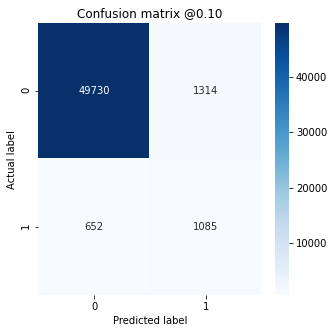



Model f1 score:  0.52
Model roc auc score:  0.8
Model recall:  0.62
Model precision:  0.45




Confusion matrix of model XGBoost of time 0


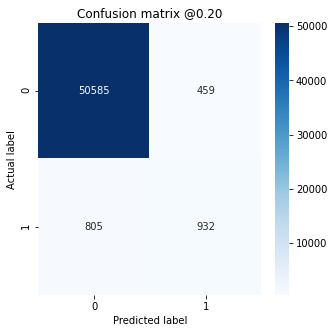



Model f1 score:  0.6
Model roc auc score:  0.76
Model recall:  0.54
Model precision:  0.67




Confusion matrix of model XGBoost of time 0


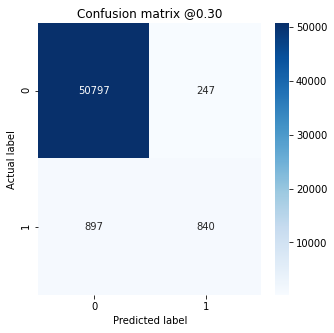



Model f1 score:  0.59
Model roc auc score:  0.74
Model recall:  0.48
Model precision:  0.77




Confusion matrix of model XGBoost of time 0


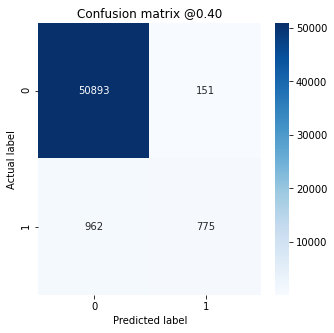



Model f1 score:  0.58
Model roc auc score:  0.72
Model recall:  0.45
Model precision:  0.84




Confusion matrix of model XGBoost of time 0


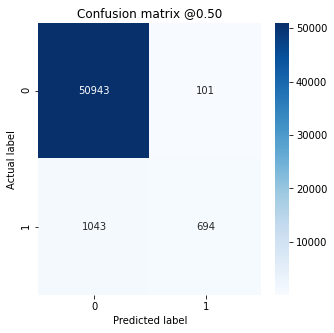



Model f1 score:  0.55
Model roc auc score:  0.7
Model recall:  0.4
Model precision:  0.87




Confusion matrix of model XGBoost of time 0


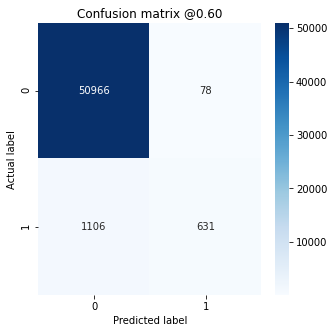



Model f1 score:  0.52
Model roc auc score:  0.68
Model recall:  0.36
Model precision:  0.89




Confusion matrix of model XGBoost of time 0


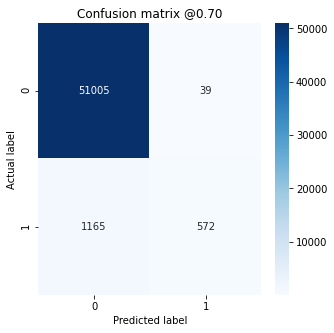



Model f1 score:  0.49
Model roc auc score:  0.66
Model recall:  0.33
Model precision:  0.94




Confusion matrix of model XGBoost of time 0


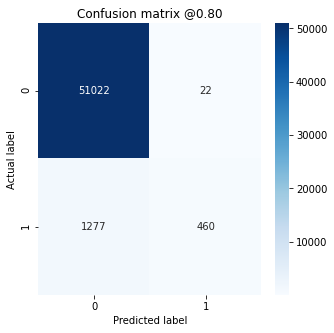



Model f1 score:  0.41
Model roc auc score:  0.63
Model recall:  0.26
Model precision:  0.95




Confusion matrix of model XGBoost of time 0


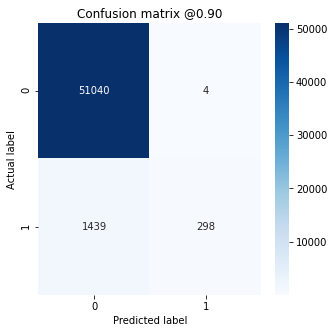



Model f1 score:  0.29
Model roc auc score:  0.59
Model recall:  0.17
Model precision:  0.99




Confusion matrix of model XGBoost of time 0


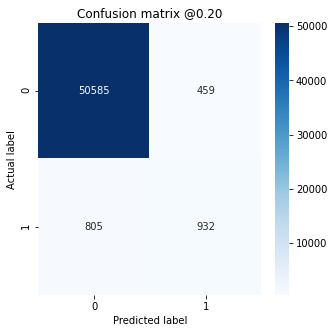



Model f1 score:  0.6
Model roc auc score:  0.76
Model recall:  0.54
Model precision:  0.67


Training Neural network
Epoch 1/30
676/676 [==============================] - 8s 7ms/step - loss: 0.1582 - accuracy: 0.9126 - recall: 0.2887 - precision: 0.1891 - val_loss: 0.1134 - val_accuracy: 0.9703 - val_recall: 0.1934 - val_precision: 0.6878
Epoch 2/30
676/676 [==============================] - 4s 6ms/step - loss: 0.0865 - accuracy: 0.9684 - recall: 0.2901 - precision: 0.5669 - val_loss: 0.1132 - val_accuracy: 0.9674 - val_recall: 0.3298 - val_precision: 0.5139
Epoch 3/30
676/676 [==============================] - 4s 6ms/step - loss: 0.0801 - accuracy: 0.9713 - recall: 0.3202 - precision: 0.6222 - val_loss: 0.1404 - val_accuracy: 0.9579 - val_recall: 0.4425 - val_precision: 0.3839
Epoch 4/30
676/676 [==============================] - 4s 6ms/step - loss: 0.0792 - accuracy: 0.9713 - recall: 0.3402 - precision: 0.6302 - val_loss: 0.1064 - val_accuracy: 0.9711 - val_recall: 0.1556 - val_pre

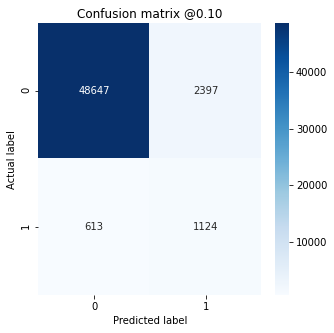



Model f1 score:  0.43
Model roc auc score:  0.8
Model recall:  0.65
Model precision:  0.32


[0.01743599 0.00342986 0.00038412 ... 0.01135403 0.02691589 0.00039097]


Confusion matrix of model Neural network of time 0


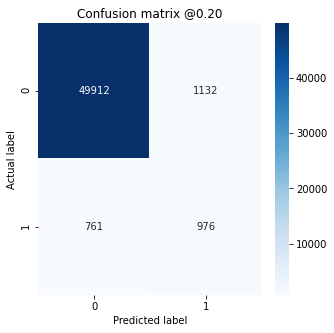



Model f1 score:  0.51
Model roc auc score:  0.77
Model recall:  0.56
Model precision:  0.46


[0.01743599 0.00342986 0.00038412 ... 0.01135403 0.02691589 0.00039097]


Confusion matrix of model Neural network of time 0


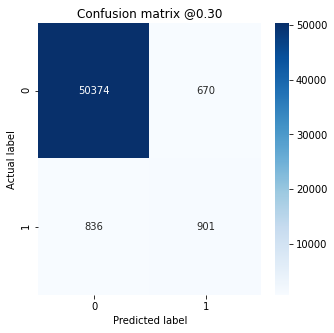



Model f1 score:  0.54
Model roc auc score:  0.75
Model recall:  0.52
Model precision:  0.57


[0.01743599 0.00342986 0.00038412 ... 0.01135403 0.02691589 0.00039097]


Confusion matrix of model Neural network of time 0


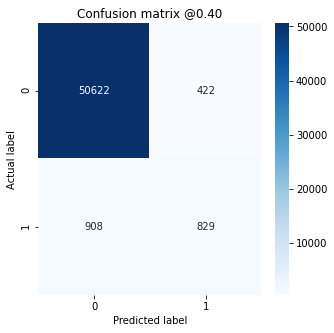



Model f1 score:  0.55
Model roc auc score:  0.73
Model recall:  0.48
Model precision:  0.66


[0.01743599 0.00342986 0.00038412 ... 0.01135403 0.02691589 0.00039097]


Confusion matrix of model Neural network of time 0


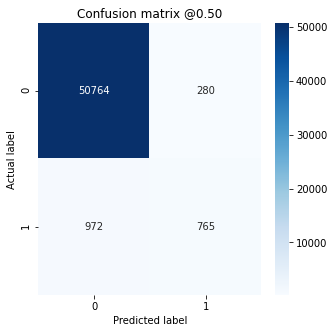



Model f1 score:  0.55
Model roc auc score:  0.72
Model recall:  0.44
Model precision:  0.73


[0.01743599 0.00342986 0.00038412 ... 0.01135403 0.02691589 0.00039097]


Confusion matrix of model Neural network of time 0


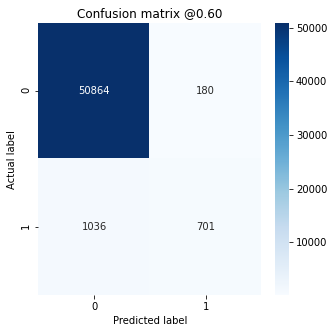



Model f1 score:  0.54
Model roc auc score:  0.7
Model recall:  0.4
Model precision:  0.8


[0.01743599 0.00342986 0.00038412 ... 0.01135403 0.02691589 0.00039097]


Confusion matrix of model Neural network of time 0


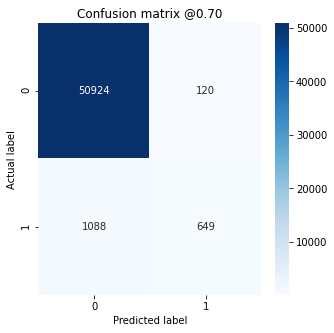



Model f1 score:  0.52
Model roc auc score:  0.69
Model recall:  0.37
Model precision:  0.84


[0.01743599 0.00342986 0.00038412 ... 0.01135403 0.02691589 0.00039097]


Confusion matrix of model Neural network of time 0


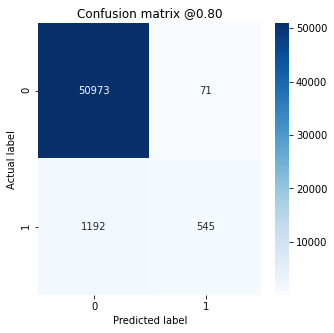



Model f1 score:  0.46
Model roc auc score:  0.66
Model recall:  0.31
Model precision:  0.88


[0.01743599 0.00342986 0.00038412 ... 0.01135403 0.02691589 0.00039097]


Confusion matrix of model Neural network of time 0


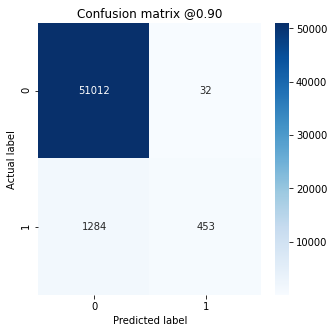



Model f1 score:  0.41
Model roc auc score:  0.63
Model recall:  0.26
Model precision:  0.93


[0.01743599 0.00342986 0.00038412 ... 0.01135403 0.02691589 0.00039097]


Confusion matrix of model Neural network of time 0


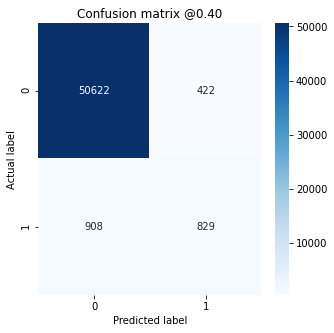



Model f1 score:  0.55
Model roc auc score:  0.73
Model recall:  0.48
Model precision:  0.66


Training svm


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)




Confusion matrix of model svm of time 0


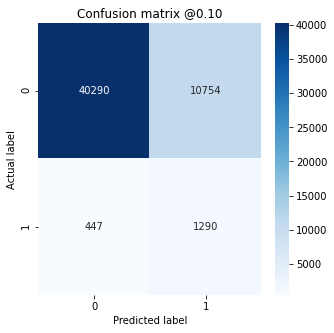



Model f1 score:  0.19
Model roc auc score:  0.77
Model recall:  0.74
Model precision:  0.11




Confusion matrix of model svm of time 0


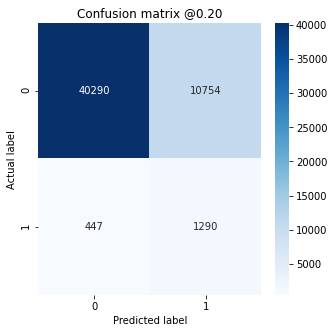



Model f1 score:  0.19
Model roc auc score:  0.77
Model recall:  0.74
Model precision:  0.11




Confusion matrix of model svm of time 0


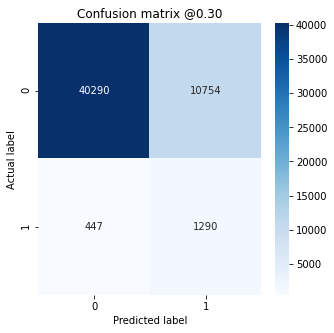



Model f1 score:  0.19
Model roc auc score:  0.77
Model recall:  0.74
Model precision:  0.11




Confusion matrix of model svm of time 0


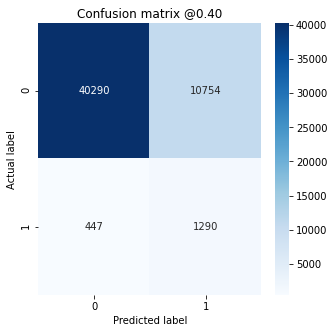



Model f1 score:  0.19
Model roc auc score:  0.77
Model recall:  0.74
Model precision:  0.11




Confusion matrix of model svm of time 0


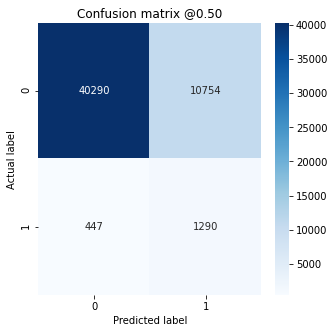



Model f1 score:  0.19
Model roc auc score:  0.77
Model recall:  0.74
Model precision:  0.11




Confusion matrix of model svm of time 0


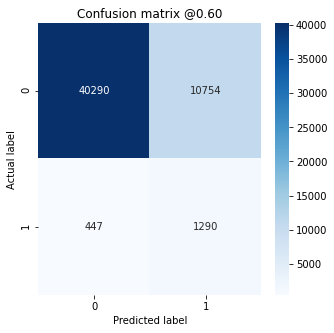



Model f1 score:  0.19
Model roc auc score:  0.77
Model recall:  0.74
Model precision:  0.11




Confusion matrix of model svm of time 0


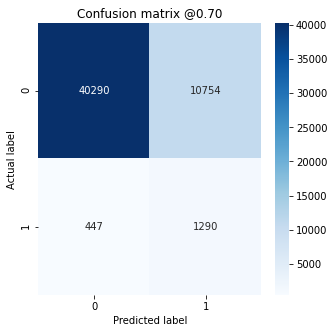



Model f1 score:  0.19
Model roc auc score:  0.77
Model recall:  0.74
Model precision:  0.11




Confusion matrix of model svm of time 0


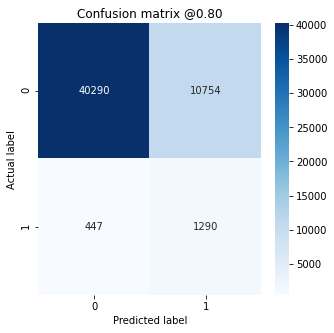



Model f1 score:  0.19
Model roc auc score:  0.77
Model recall:  0.74
Model precision:  0.11




Confusion matrix of model svm of time 0


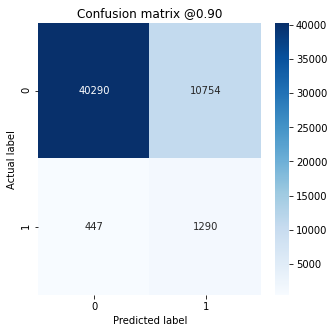



Model f1 score:  0.19
Model roc auc score:  0.77
Model recall:  0.74
Model precision:  0.11




Confusion matrix of model svm of time 0


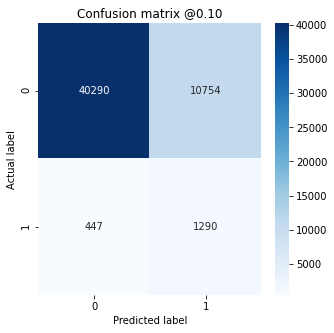



Model f1 score:  0.19
Model roc auc score:  0.77
Model recall:  0.74
Model precision:  0.11


XGBoost has been chosen.
Time  1
Training XGBoost


Confusion matrix of model XGBoost of time 1


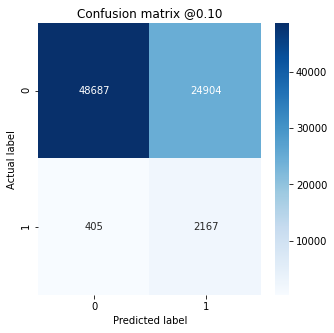



Model f1 score:  0.15
Model roc auc score:  0.75
Model recall:  0.84
Model precision:  0.08




Confusion matrix of model XGBoost of time 1


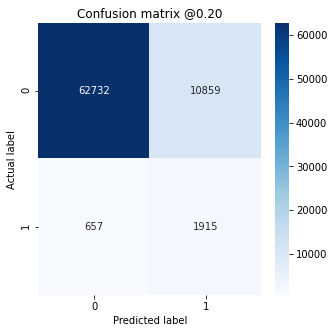



Model f1 score:  0.25
Model roc auc score:  0.8
Model recall:  0.74
Model precision:  0.15




Confusion matrix of model XGBoost of time 1


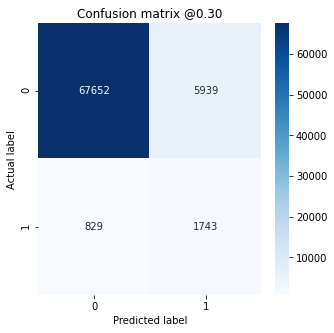



Model f1 score:  0.34
Model roc auc score:  0.8
Model recall:  0.68
Model precision:  0.23




Confusion matrix of model XGBoost of time 1


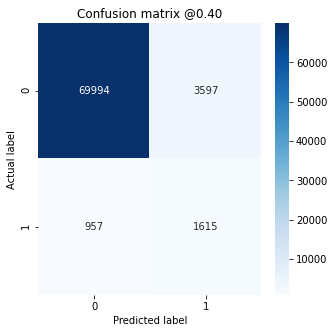



Model f1 score:  0.41
Model roc auc score:  0.79
Model recall:  0.63
Model precision:  0.31




Confusion matrix of model XGBoost of time 1


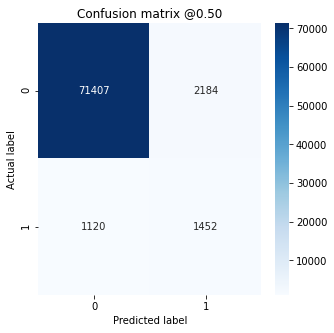



Model f1 score:  0.47
Model roc auc score:  0.77
Model recall:  0.56
Model precision:  0.4




Confusion matrix of model XGBoost of time 1


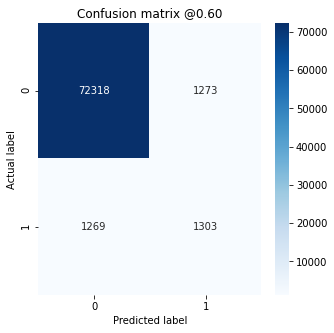



Model f1 score:  0.51
Model roc auc score:  0.74
Model recall:  0.51
Model precision:  0.51




Confusion matrix of model XGBoost of time 1


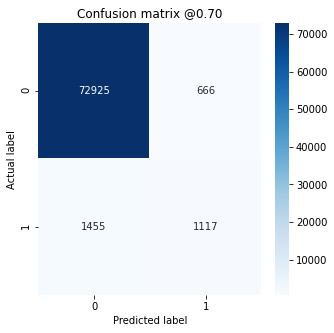



Model f1 score:  0.51
Model roc auc score:  0.71
Model recall:  0.43
Model precision:  0.63




Confusion matrix of model XGBoost of time 1


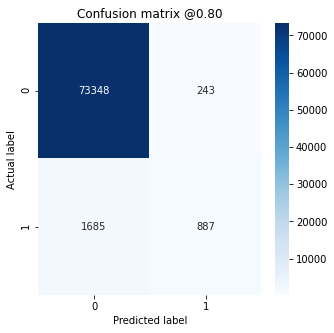



Model f1 score:  0.48
Model roc auc score:  0.67
Model recall:  0.34
Model precision:  0.78




Confusion matrix of model XGBoost of time 1


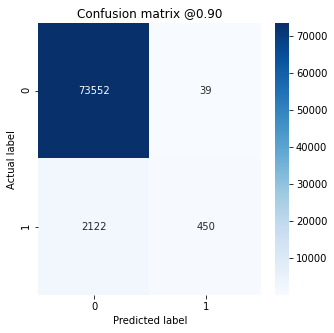



Model f1 score:  0.29
Model roc auc score:  0.59
Model recall:  0.17
Model precision:  0.92




Confusion matrix of model XGBoost of time 1


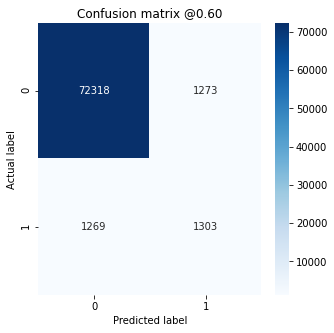



Model f1 score:  0.51
Model roc auc score:  0.74
Model recall:  0.51
Model precision:  0.51


Training Neural network
Epoch 1/30
395/395 [==============================] - 4s 7ms/step - loss: 0.2315 - accuracy: 0.8472 - recall_1: 0.5757 - precision_1: 0.3785 - val_loss: 0.2305 - val_accuracy: 0.9203 - val_recall_1: 0.2527 - val_precision_1: 0.7782
Epoch 2/30
395/395 [==============================] - 2s 6ms/step - loss: 0.1590 - accuracy: 0.9187 - recall_1: 0.5272 - precision_1: 0.5952 - val_loss: 0.2165 - val_accuracy: 0.9194 - val_recall_1: 0.5595 - val_precision_1: 0.5908
Epoch 3/30
395/395 [==============================] - 2s 6ms/step - loss: 0.1525 - accuracy: 0.9223 - recall_1: 0.5477 - precision_1: 0.6153 - val_loss: 0.2045 - val_accuracy: 0.9238 - val_recall_1: 0.5162 - val_precision_1: 0.6333
Epoch 4/30
395/395 [==============================] - 2s 6ms/step - loss: 0.1498 - accuracy: 0.9242 - recall_1: 0.5766 - precision_1: 0.6324 - val_loss: 0.2053 - val_accuracy: 0.9274 -

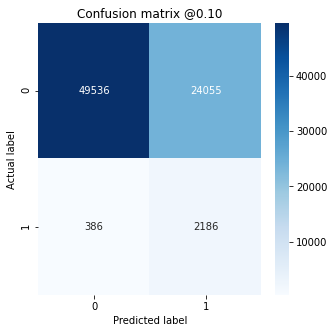



Model f1 score:  0.15
Model roc auc score:  0.76
Model recall:  0.85
Model precision:  0.08


[0.0642433  0.01675091 0.0009354  ... 0.0042125  0.39581063 0.00161097]


Confusion matrix of model Neural network of time 1


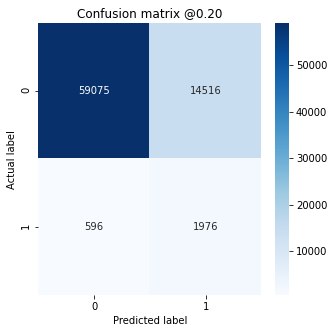



Model f1 score:  0.21
Model roc auc score:  0.79
Model recall:  0.77
Model precision:  0.12


[0.0642433  0.01675091 0.0009354  ... 0.0042125  0.39581063 0.00161097]


Confusion matrix of model Neural network of time 1


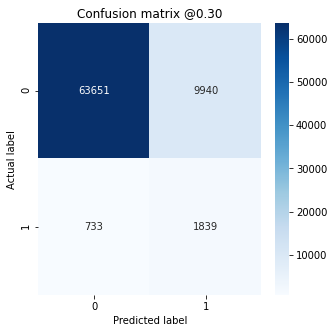



Model f1 score:  0.26
Model roc auc score:  0.79
Model recall:  0.72
Model precision:  0.16


[0.0642433  0.01675091 0.0009354  ... 0.0042125  0.39581063 0.00161097]


Confusion matrix of model Neural network of time 1


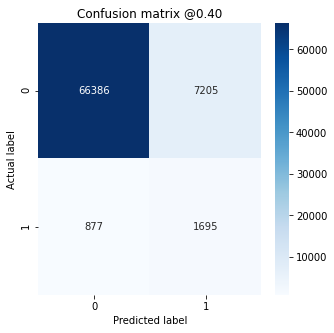



Model f1 score:  0.3
Model roc auc score:  0.78
Model recall:  0.66
Model precision:  0.19


[0.0642433  0.01675091 0.0009354  ... 0.0042125  0.39581063 0.00161097]


Confusion matrix of model Neural network of time 1


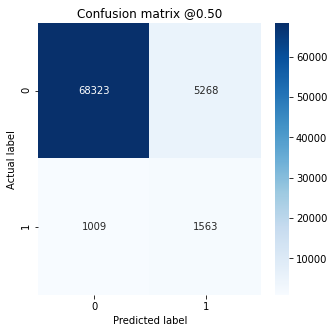



Model f1 score:  0.33
Model roc auc score:  0.77
Model recall:  0.61
Model precision:  0.23


[0.0642433  0.01675091 0.0009354  ... 0.0042125  0.39581063 0.00161097]


Confusion matrix of model Neural network of time 1


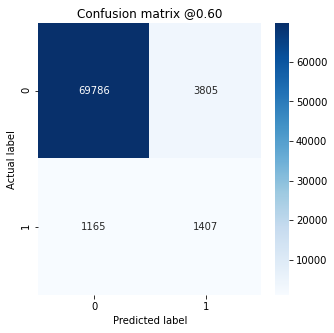



Model f1 score:  0.36
Model roc auc score:  0.75
Model recall:  0.55
Model precision:  0.27


[0.0642433  0.01675091 0.0009354  ... 0.0042125  0.39581063 0.00161097]


Confusion matrix of model Neural network of time 1


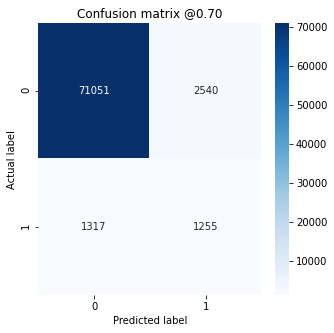



Model f1 score:  0.39
Model roc auc score:  0.73
Model recall:  0.49
Model precision:  0.33


[0.0642433  0.01675091 0.0009354  ... 0.0042125  0.39581063 0.00161097]


Confusion matrix of model Neural network of time 1


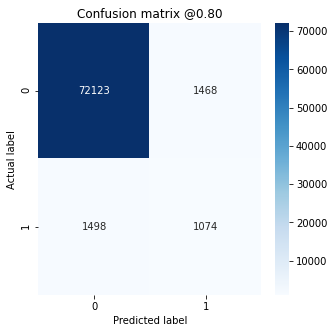



Model f1 score:  0.42
Model roc auc score:  0.7
Model recall:  0.42
Model precision:  0.42


[0.0642433  0.01675091 0.0009354  ... 0.0042125  0.39581063 0.00161097]


Confusion matrix of model Neural network of time 1


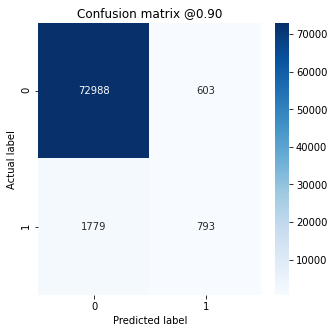



Model f1 score:  0.4
Model roc auc score:  0.65
Model recall:  0.31
Model precision:  0.57


[0.0642433  0.01675091 0.0009354  ... 0.0042125  0.39581063 0.00161097]


Confusion matrix of model Neural network of time 1


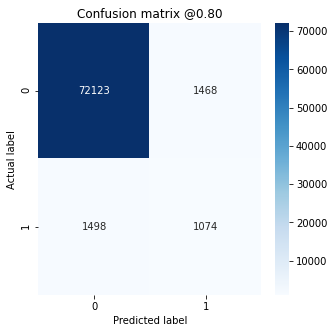



Model f1 score:  0.42
Model roc auc score:  0.7
Model recall:  0.42
Model precision:  0.42


Training svm


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)




Confusion matrix of model svm of time 1


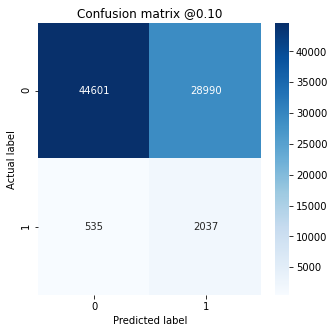



Model f1 score:  0.12
Model roc auc score:  0.7
Model recall:  0.79
Model precision:  0.07




Confusion matrix of model svm of time 1


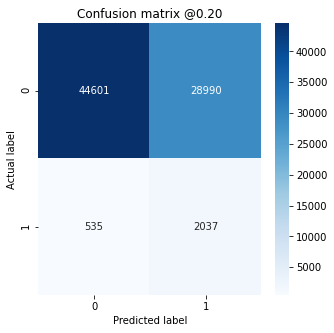



Model f1 score:  0.12
Model roc auc score:  0.7
Model recall:  0.79
Model precision:  0.07




Confusion matrix of model svm of time 1


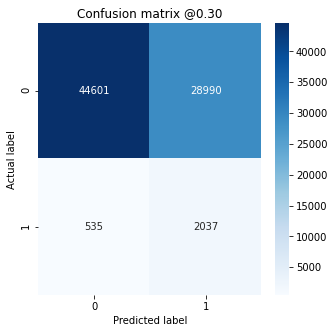



Model f1 score:  0.12
Model roc auc score:  0.7
Model recall:  0.79
Model precision:  0.07




Confusion matrix of model svm of time 1


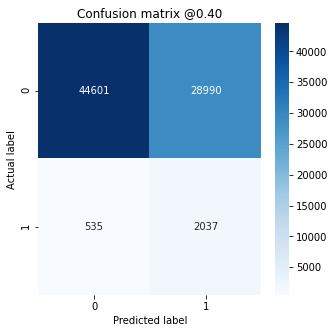



Model f1 score:  0.12
Model roc auc score:  0.7
Model recall:  0.79
Model precision:  0.07




Confusion matrix of model svm of time 1


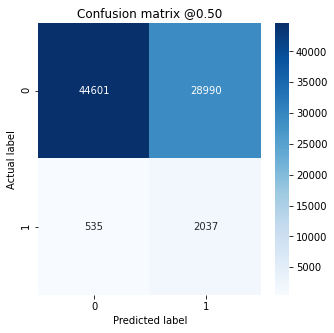



Model f1 score:  0.12
Model roc auc score:  0.7
Model recall:  0.79
Model precision:  0.07




Confusion matrix of model svm of time 1


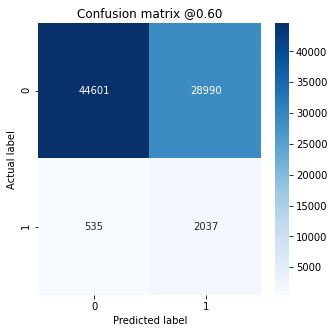



Model f1 score:  0.12
Model roc auc score:  0.7
Model recall:  0.79
Model precision:  0.07




Confusion matrix of model svm of time 1


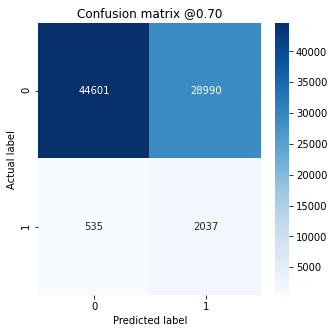



Model f1 score:  0.12
Model roc auc score:  0.7
Model recall:  0.79
Model precision:  0.07




Confusion matrix of model svm of time 1


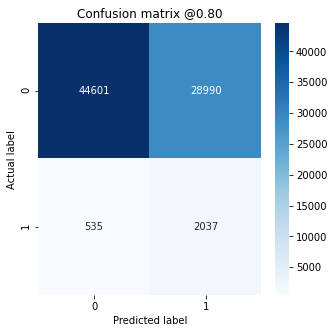



Model f1 score:  0.12
Model roc auc score:  0.7
Model recall:  0.79
Model precision:  0.07




Confusion matrix of model svm of time 1


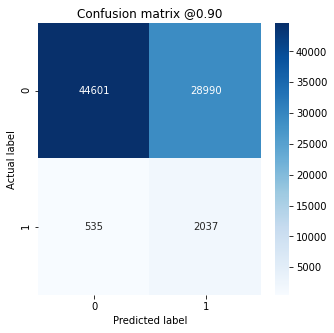



Model f1 score:  0.12
Model roc auc score:  0.7
Model recall:  0.79
Model precision:  0.07




Confusion matrix of model svm of time 1


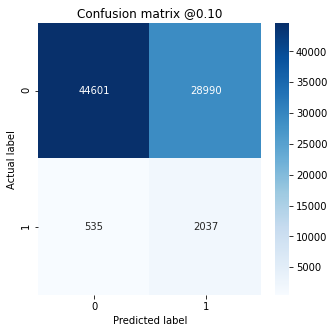



Model f1 score:  0.12
Model roc auc score:  0.7
Model recall:  0.79
Model precision:  0.07


XGBoost has been chosen.


Confusion matrix of model Ensemble of time 1


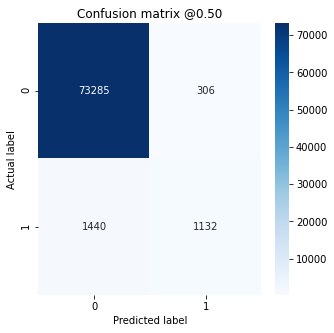



Model f1 score:  0.56
Model roc auc score:  0.72
Model recall:  0.44
Model precision:  0.79


Time  2
Training XGBoost


Confusion matrix of model XGBoost of time 2


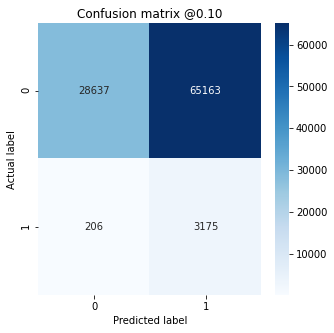



Model f1 score:  0.09
Model roc auc score:  0.62
Model recall:  0.94
Model precision:  0.05




Confusion matrix of model XGBoost of time 2


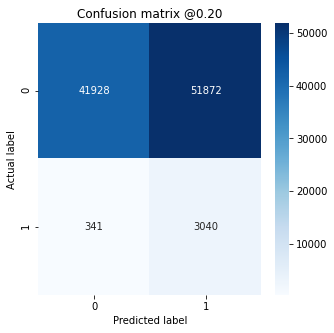



Model f1 score:  0.1
Model roc auc score:  0.67
Model recall:  0.9
Model precision:  0.06




Confusion matrix of model XGBoost of time 2


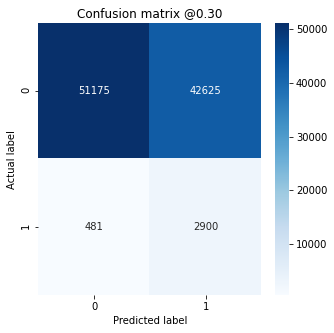



Model f1 score:  0.12
Model roc auc score:  0.7
Model recall:  0.86
Model precision:  0.06




Confusion matrix of model XGBoost of time 2


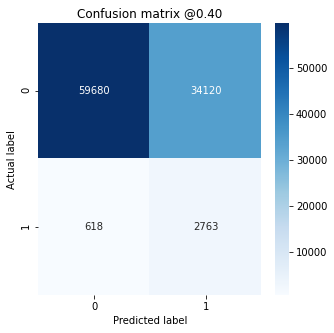



Model f1 score:  0.14
Model roc auc score:  0.73
Model recall:  0.82
Model precision:  0.07




Confusion matrix of model XGBoost of time 2


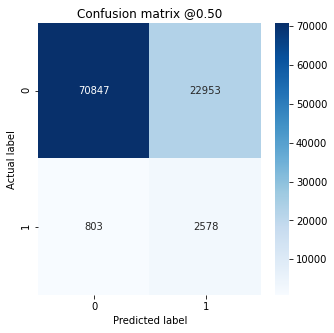



Model f1 score:  0.18
Model roc auc score:  0.76
Model recall:  0.76
Model precision:  0.1




Confusion matrix of model XGBoost of time 2


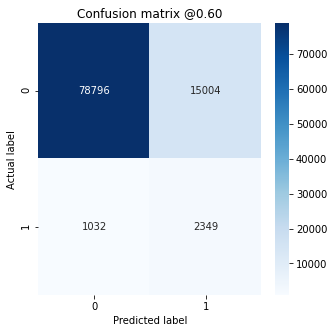



Model f1 score:  0.23
Model roc auc score:  0.77
Model recall:  0.69
Model precision:  0.14




Confusion matrix of model XGBoost of time 2


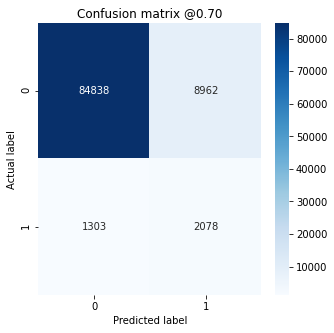



Model f1 score:  0.29
Model roc auc score:  0.76
Model recall:  0.61
Model precision:  0.19




Confusion matrix of model XGBoost of time 2


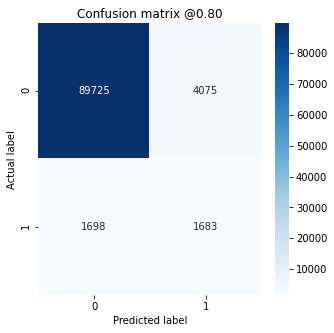



Model f1 score:  0.37
Model roc auc score:  0.73
Model recall:  0.5
Model precision:  0.29




Confusion matrix of model XGBoost of time 2


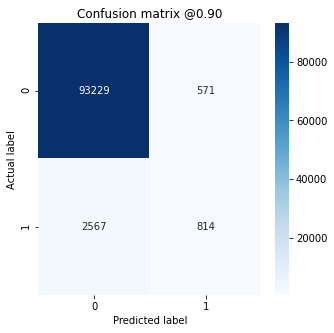



Model f1 score:  0.34
Model roc auc score:  0.62
Model recall:  0.24
Model precision:  0.59




Confusion matrix of model XGBoost of time 2


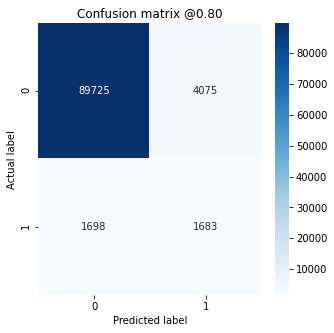



Model f1 score:  0.37
Model roc auc score:  0.73
Model recall:  0.5
Model precision:  0.29


Training Neural network
Epoch 1/30
364/364 [==============================] - 4s 8ms/step - loss: 0.2549 - accuracy: 0.8392 - recall_2: 0.7037 - precision_2: 0.5529 - val_loss: 0.3257 - val_accuracy: 0.8947 - val_recall_2: 0.5890 - val_precision_2: 0.7733
Epoch 2/30
364/364 [==============================] - 2s 7ms/step - loss: 0.1998 - accuracy: 0.8879 - recall_2: 0.7052 - precision_2: 0.6827 - val_loss: 0.3406 - val_accuracy: 0.8758 - val_recall_2: 0.7563 - val_precision_2: 0.6296
Epoch 3/30
364/364 [==============================] - 2s 7ms/step - loss: 0.1949 - accuracy: 0.8916 - recall_2: 0.7200 - precision_2: 0.6922 - val_loss: 0.2901 - val_accuracy: 0.8834 - val_recall_2: 0.7321 - val_precision_2: 0.6590
Epoch 4/30
364/364 [==============================] - 2s 7ms/step - loss: 0.1870 - accuracy: 0.8963 - recall_2: 0.7312 - precision_2: 0.7004 - val_loss: 0.2670 - val_accuracy: 0.8974 - 

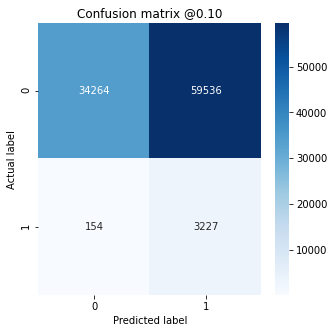



Model f1 score:  0.1
Model roc auc score:  0.66
Model recall:  0.95
Model precision:  0.05


[0.31797186 0.26212087 0.05414562 ... 0.03818764 0.20303878 0.06351995]


Confusion matrix of model Neural network of time 2


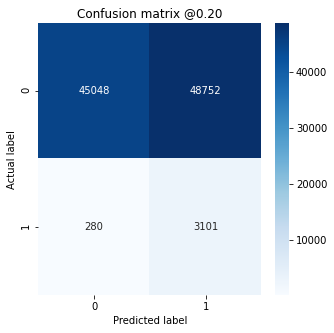



Model f1 score:  0.11
Model roc auc score:  0.7
Model recall:  0.92
Model precision:  0.06


[0.31797186 0.26212087 0.05414562 ... 0.03818764 0.20303878 0.06351995]


Confusion matrix of model Neural network of time 2


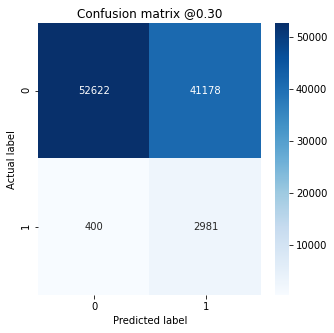



Model f1 score:  0.13
Model roc auc score:  0.72
Model recall:  0.88
Model precision:  0.07


[0.31797186 0.26212087 0.05414562 ... 0.03818764 0.20303878 0.06351995]


Confusion matrix of model Neural network of time 2


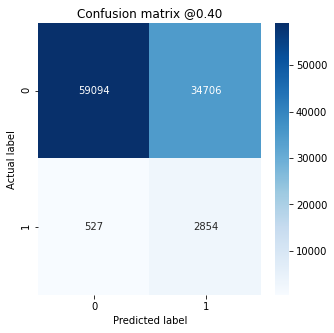



Model f1 score:  0.14
Model roc auc score:  0.74
Model recall:  0.84
Model precision:  0.08


[0.31797186 0.26212087 0.05414562 ... 0.03818764 0.20303878 0.06351995]


Confusion matrix of model Neural network of time 2


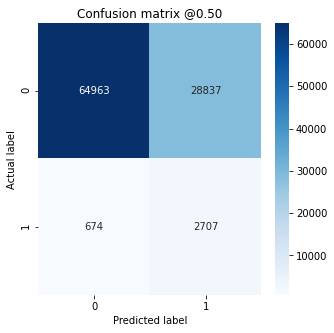



Model f1 score:  0.16
Model roc auc score:  0.75
Model recall:  0.8
Model precision:  0.09


[0.31797186 0.26212087 0.05414562 ... 0.03818764 0.20303878 0.06351995]


Confusion matrix of model Neural network of time 2


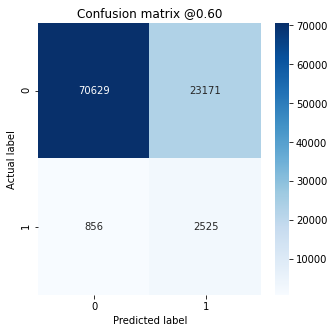



Model f1 score:  0.17
Model roc auc score:  0.75
Model recall:  0.75
Model precision:  0.1


[0.31797186 0.26212087 0.05414562 ... 0.03818764 0.20303878 0.06351995]


Confusion matrix of model Neural network of time 2


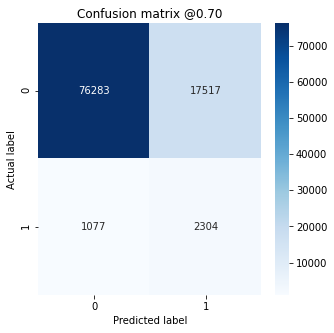



Model f1 score:  0.2
Model roc auc score:  0.75
Model recall:  0.68
Model precision:  0.12


[0.31797186 0.26212087 0.05414562 ... 0.03818764 0.20303878 0.06351995]


Confusion matrix of model Neural network of time 2


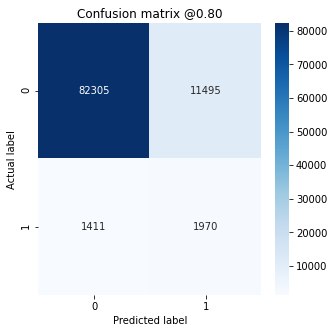



Model f1 score:  0.23
Model roc auc score:  0.73
Model recall:  0.58
Model precision:  0.15


[0.31797186 0.26212087 0.05414562 ... 0.03818764 0.20303878 0.06351995]


Confusion matrix of model Neural network of time 2


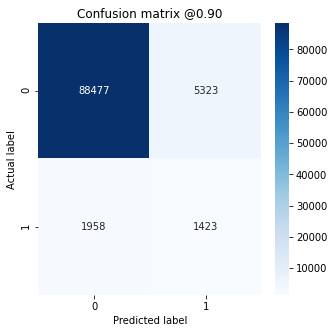



Model f1 score:  0.28
Model roc auc score:  0.68
Model recall:  0.42
Model precision:  0.21


[0.31797186 0.26212087 0.05414562 ... 0.03818764 0.20303878 0.06351995]


Confusion matrix of model Neural network of time 2


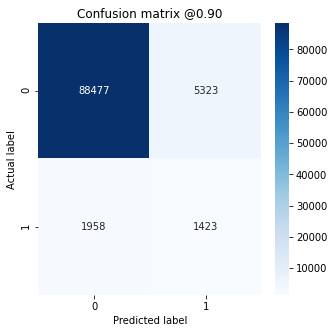



Model f1 score:  0.28
Model roc auc score:  0.68
Model recall:  0.42
Model precision:  0.21


Training svm


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)




Confusion matrix of model svm of time 2


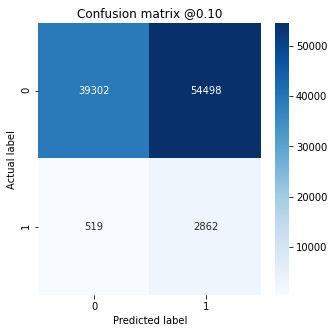



Model f1 score:  0.09
Model roc auc score:  0.63
Model recall:  0.85
Model precision:  0.05




Confusion matrix of model svm of time 2


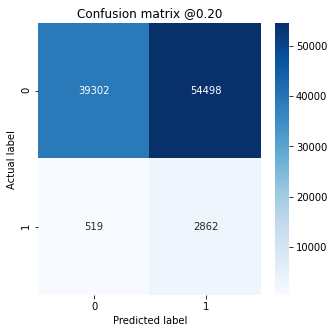



Model f1 score:  0.09
Model roc auc score:  0.63
Model recall:  0.85
Model precision:  0.05




Confusion matrix of model svm of time 2


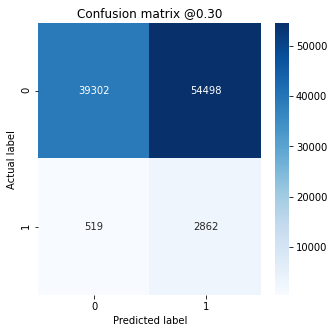



Model f1 score:  0.09
Model roc auc score:  0.63
Model recall:  0.85
Model precision:  0.05




Confusion matrix of model svm of time 2


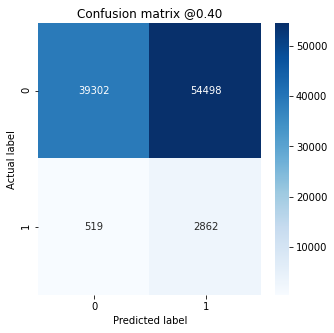



Model f1 score:  0.09
Model roc auc score:  0.63
Model recall:  0.85
Model precision:  0.05




Confusion matrix of model svm of time 2


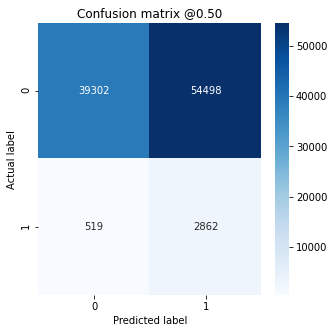



Model f1 score:  0.09
Model roc auc score:  0.63
Model recall:  0.85
Model precision:  0.05




Confusion matrix of model svm of time 2


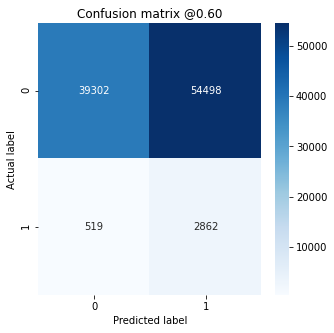



Model f1 score:  0.09
Model roc auc score:  0.63
Model recall:  0.85
Model precision:  0.05




Confusion matrix of model svm of time 2


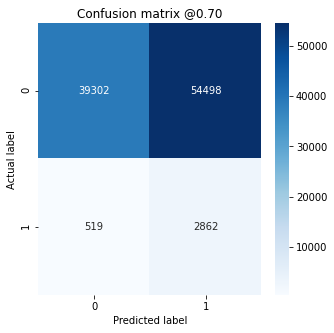



Model f1 score:  0.09
Model roc auc score:  0.63
Model recall:  0.85
Model precision:  0.05




Confusion matrix of model svm of time 2


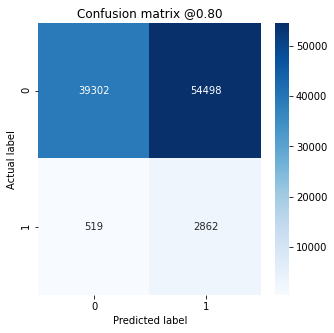



Model f1 score:  0.09
Model roc auc score:  0.63
Model recall:  0.85
Model precision:  0.05




Confusion matrix of model svm of time 2


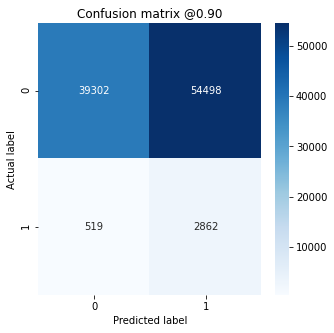



Model f1 score:  0.09
Model roc auc score:  0.63
Model recall:  0.85
Model precision:  0.05




Confusion matrix of model svm of time 2


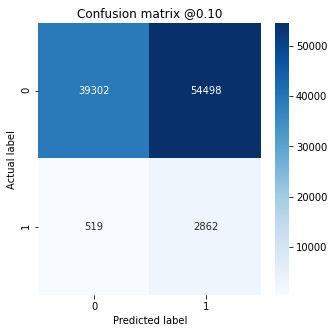



Model f1 score:  0.09
Model roc auc score:  0.63
Model recall:  0.85
Model precision:  0.05


XGBoost has been chosen.


Confusion matrix of model Ensemble of time 2


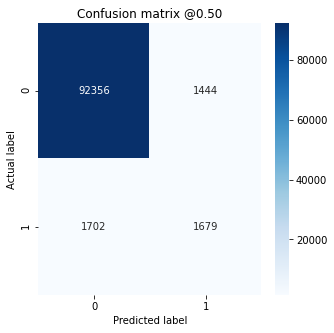



Model f1 score:  0.52
Model roc auc score:  0.74
Model recall:  0.5
Model precision:  0.54


Time  3
Training XGBoost


Confusion matrix of model XGBoost of time 3


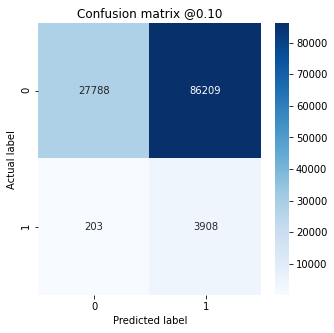



Model f1 score:  0.08
Model roc auc score:  0.6
Model recall:  0.95
Model precision:  0.04




Confusion matrix of model XGBoost of time 3


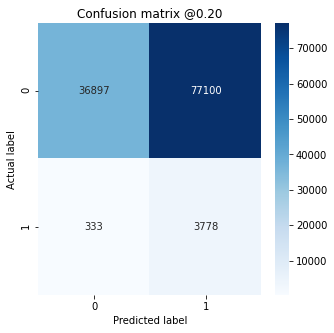



Model f1 score:  0.09
Model roc auc score:  0.62
Model recall:  0.92
Model precision:  0.05




Confusion matrix of model XGBoost of time 3


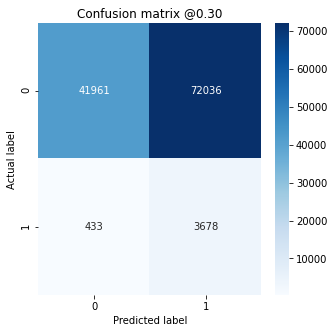



Model f1 score:  0.09
Model roc auc score:  0.63
Model recall:  0.89
Model precision:  0.05




Confusion matrix of model XGBoost of time 3


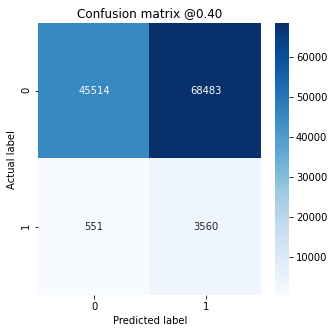



Model f1 score:  0.09
Model roc auc score:  0.63
Model recall:  0.87
Model precision:  0.05




Confusion matrix of model XGBoost of time 3


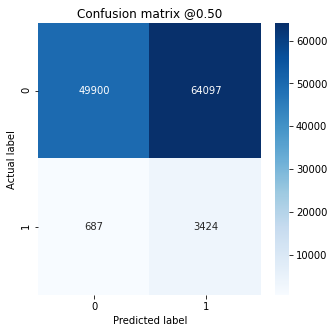



Model f1 score:  0.1
Model roc auc score:  0.64
Model recall:  0.83
Model precision:  0.05




Confusion matrix of model XGBoost of time 3


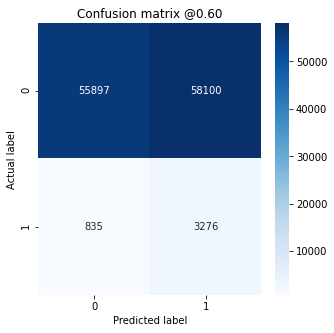



Model f1 score:  0.1
Model roc auc score:  0.64
Model recall:  0.8
Model precision:  0.05




Confusion matrix of model XGBoost of time 3


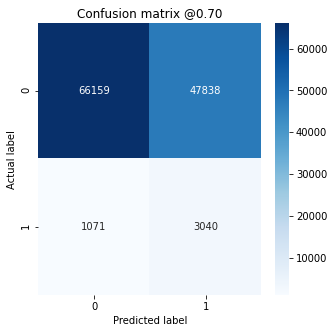



Model f1 score:  0.11
Model roc auc score:  0.66
Model recall:  0.74
Model precision:  0.06




Confusion matrix of model XGBoost of time 3


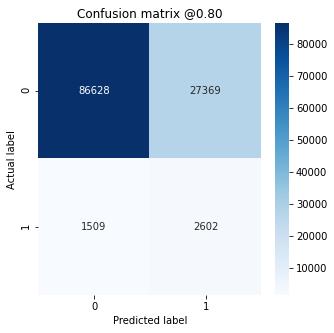



Model f1 score:  0.15
Model roc auc score:  0.7
Model recall:  0.63
Model precision:  0.09




Confusion matrix of model XGBoost of time 3


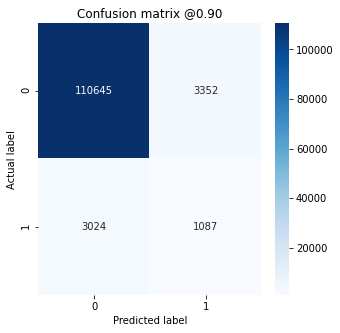



Model f1 score:  0.25
Model roc auc score:  0.62
Model recall:  0.26
Model precision:  0.24




Confusion matrix of model XGBoost of time 3


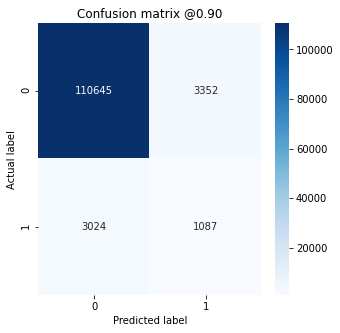



Model f1 score:  0.25
Model roc auc score:  0.62
Model recall:  0.26
Model precision:  0.24


Training Neural network
Epoch 1/30
371/371 [==============================] - 4s 9ms/step - loss: 0.2472 - accuracy: 0.8457 - recall_3: 0.7425 - precision_3: 0.6121 - val_loss: 0.2951 - val_accuracy: 0.8830 - val_recall_3: 0.5198 - val_precision_3: 0.8413
Epoch 2/30
371/371 [==============================] - 3s 7ms/step - loss: 0.1929 - accuracy: 0.8992 - recall_3: 0.7649 - precision_3: 0.7459 - val_loss: 0.4381 - val_accuracy: 0.8266 - val_recall_3: 0.8861 - val_precision_3: 0.5438
Epoch 3/30
371/371 [==============================] - 3s 7ms/step - loss: 0.1871 - accuracy: 0.9016 - recall_3: 0.7705 - precision_3: 0.7478 - val_loss: 0.2761 - val_accuracy: 0.9014 - val_recall_3: 0.7904 - val_precision_3: 0.7397
Epoch 4/30
371/371 [==============================] - 3s 7ms/step - loss: 0.1823 - accuracy: 0.9056 - recall_3: 0.7811 - precision_3: 0.7595 - val_loss: 0.2790 - val_accuracy: 0.8973 -

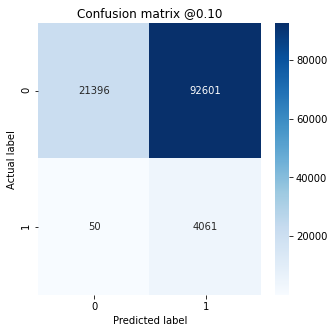



Model f1 score:  0.08
Model roc auc score:  0.59
Model recall:  0.99
Model precision:  0.04


[0.9054953  0.8663169  0.88567996 ... 0.02062682 0.10222206 0.08442179]


Confusion matrix of model Neural network of time 3


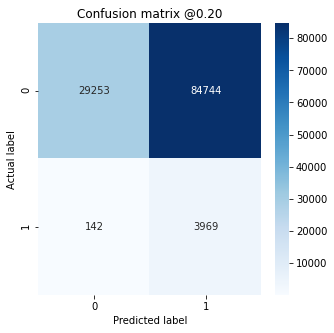



Model f1 score:  0.09
Model roc auc score:  0.61
Model recall:  0.97
Model precision:  0.04


[0.9054953  0.8663169  0.88567996 ... 0.02062682 0.10222206 0.08442179]


Confusion matrix of model Neural network of time 3


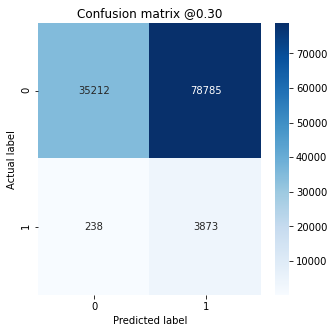



Model f1 score:  0.09
Model roc auc score:  0.63
Model recall:  0.94
Model precision:  0.05


[0.9054953  0.8663169  0.88567996 ... 0.02062682 0.10222206 0.08442179]


Confusion matrix of model Neural network of time 3


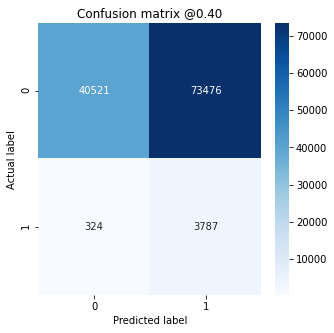



Model f1 score:  0.09
Model roc auc score:  0.64
Model recall:  0.92
Model precision:  0.05


[0.9054953  0.8663169  0.88567996 ... 0.02062682 0.10222206 0.08442179]


Confusion matrix of model Neural network of time 3


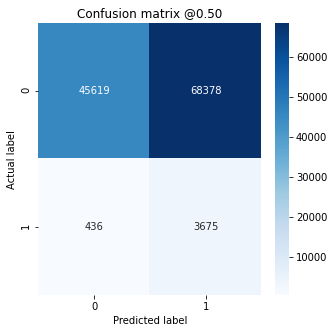



Model f1 score:  0.1
Model roc auc score:  0.65
Model recall:  0.89
Model precision:  0.05


[0.9054953  0.8663169  0.88567996 ... 0.02062682 0.10222206 0.08442179]


Confusion matrix of model Neural network of time 3


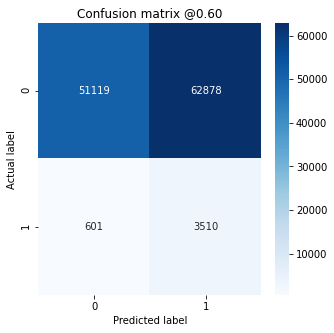



Model f1 score:  0.1
Model roc auc score:  0.65
Model recall:  0.85
Model precision:  0.05


[0.9054953  0.8663169  0.88567996 ... 0.02062682 0.10222206 0.08442179]


Confusion matrix of model Neural network of time 3


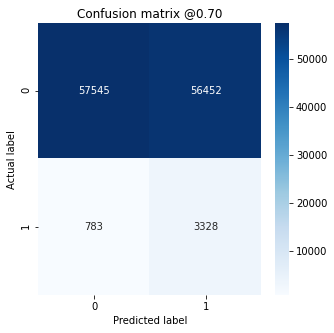



Model f1 score:  0.1
Model roc auc score:  0.66
Model recall:  0.81
Model precision:  0.06


[0.9054953  0.8663169  0.88567996 ... 0.02062682 0.10222206 0.08442179]


Confusion matrix of model Neural network of time 3


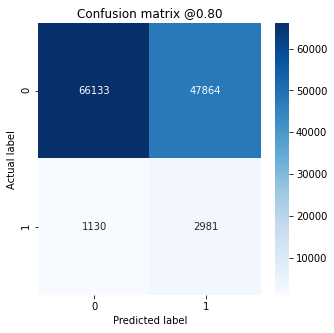



Model f1 score:  0.11
Model roc auc score:  0.65
Model recall:  0.73
Model precision:  0.06


[0.9054953  0.8663169  0.88567996 ... 0.02062682 0.10222206 0.08442179]


Confusion matrix of model Neural network of time 3


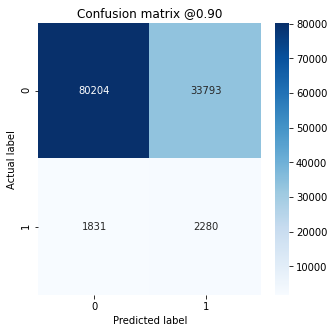



Model f1 score:  0.11
Model roc auc score:  0.63
Model recall:  0.55
Model precision:  0.06


[0.9054953  0.8663169  0.88567996 ... 0.02062682 0.10222206 0.08442179]


Confusion matrix of model Neural network of time 3


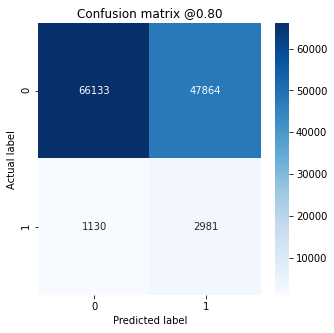



Model f1 score:  0.11
Model roc auc score:  0.65
Model recall:  0.73
Model precision:  0.06


Training svm


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)




Confusion matrix of model svm of time 3


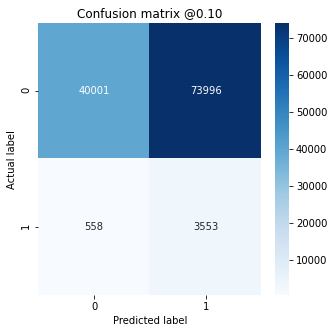



Model f1 score:  0.09
Model roc auc score:  0.61
Model recall:  0.86
Model precision:  0.05




Confusion matrix of model svm of time 3


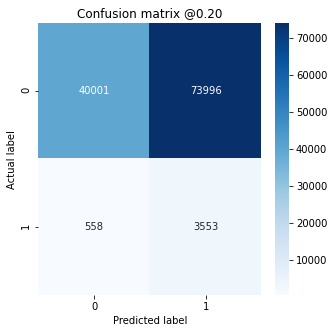



Model f1 score:  0.09
Model roc auc score:  0.61
Model recall:  0.86
Model precision:  0.05




Confusion matrix of model svm of time 3


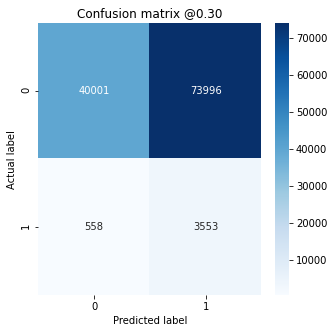



Model f1 score:  0.09
Model roc auc score:  0.61
Model recall:  0.86
Model precision:  0.05




Confusion matrix of model svm of time 3


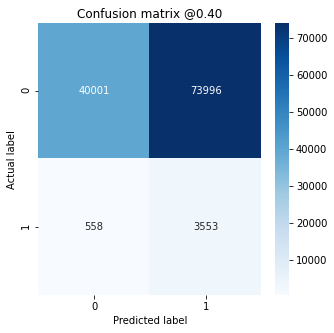



Model f1 score:  0.09
Model roc auc score:  0.61
Model recall:  0.86
Model precision:  0.05




Confusion matrix of model svm of time 3


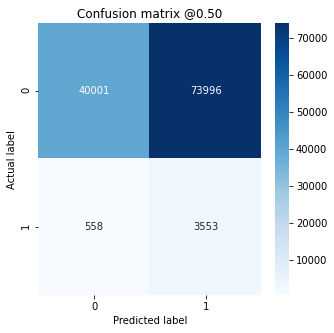



Model f1 score:  0.09
Model roc auc score:  0.61
Model recall:  0.86
Model precision:  0.05




Confusion matrix of model svm of time 3


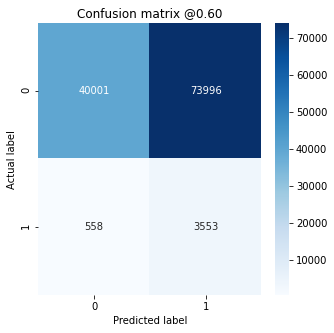



Model f1 score:  0.09
Model roc auc score:  0.61
Model recall:  0.86
Model precision:  0.05




Confusion matrix of model svm of time 3


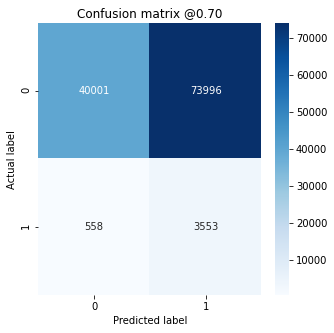



Model f1 score:  0.09
Model roc auc score:  0.61
Model recall:  0.86
Model precision:  0.05




Confusion matrix of model svm of time 3


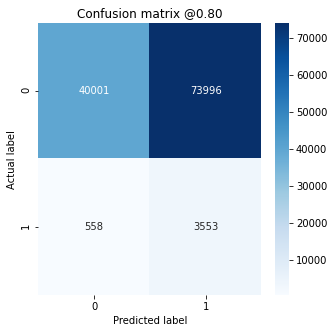



Model f1 score:  0.09
Model roc auc score:  0.61
Model recall:  0.86
Model precision:  0.05




Confusion matrix of model svm of time 3


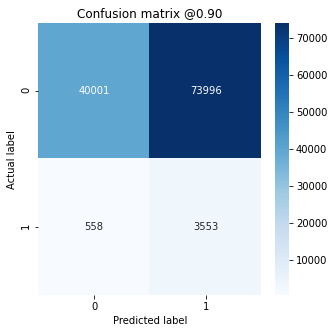



Model f1 score:  0.09
Model roc auc score:  0.61
Model recall:  0.86
Model precision:  0.05




Confusion matrix of model svm of time 3


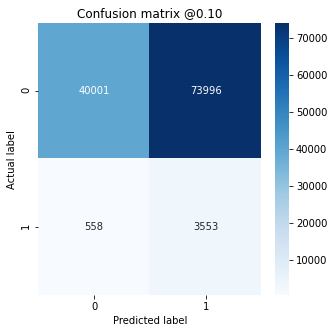



Model f1 score:  0.09
Model roc auc score:  0.61
Model recall:  0.86
Model precision:  0.05


XGBoost has been chosen.


Confusion matrix of model Ensemble of time 3


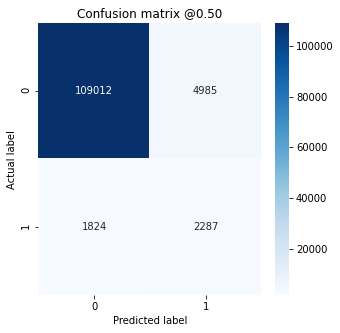



Model f1 score:  0.4
Model roc auc score:  0.76
Model recall:  0.56
Model precision:  0.31




In [18]:
id, id_fraud = get_split_id(data, init_splits, incoming_splits, tot_splits) # splitta le righe in base agli split dichiarati
model_dict, ensemble_dict = dinamic_model(data, id, id_fraud, init_splits, incoming_splits, tot_splits, keep_fraud = True, keep_safe = True)



Confusion matrix of model Ensemble of time 3


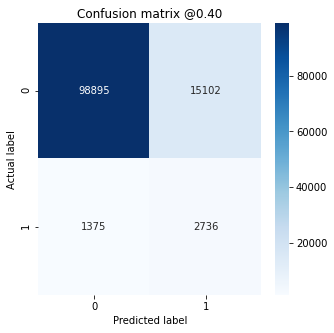



Model f1 score:  0.25
Model roc auc score:  0.77
Model recall:  0.67
Model precision:  0.15




Confusion matrix of model Ensemble of time 3


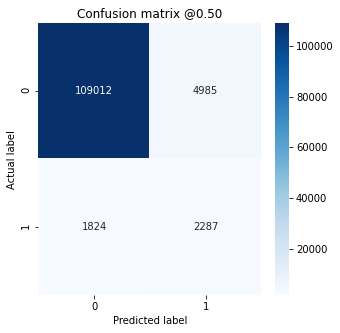



Model f1 score:  0.4
Model roc auc score:  0.76
Model recall:  0.56
Model precision:  0.31




Confusion matrix of model Ensemble of time 3


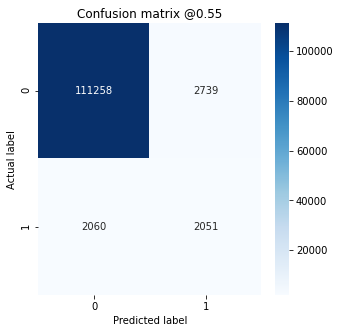



Model f1 score:  0.46
Model roc auc score:  0.74
Model recall:  0.5
Model precision:  0.43




Confusion matrix of model Ensemble of time 3


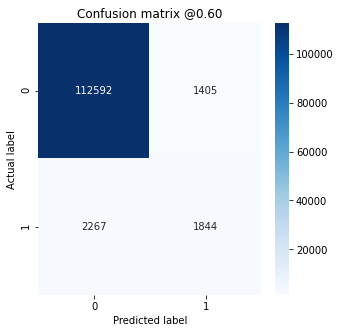



Model f1 score:  0.5
Model roc auc score:  0.72
Model recall:  0.45
Model precision:  0.57




Confusion matrix of model Ensemble of time 3


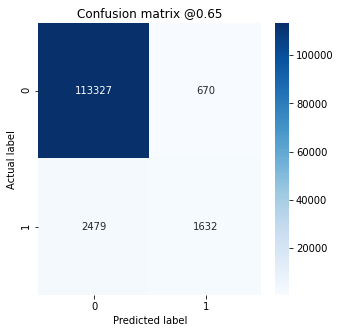



Model f1 score:  0.51
Model roc auc score:  0.7
Model recall:  0.4
Model precision:  0.71




Confusion matrix of model Ensemble of time 3


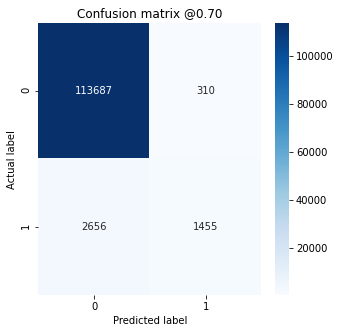



Model f1 score:  0.5
Model roc auc score:  0.68
Model recall:  0.35
Model precision:  0.82




In [19]:
t = 3
final_ensemble = ensemble_dict[t]
soglie = [0.4, 0.5, 0.55, 0.6, 0.65, 0.7]
for soglia in soglie:
  final_ensemble.prediction = []
  id_t = get_t_id(data, id, id_fraud, t, init_splits, incoming_splits) 
  test_ensemble(final_ensemble, model_dict, t, data, id_t, soglia)